In [1]:
#!/usr/bin/env python
%matplotlib widget
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import numpy as np
import random
import math
import subprocess

In [2]:
#<dimensions>
x_low = 0
x_high = 1
x_num = 27

mistake_num_max = 80
mistake_num_min = 10

k_const = 1
monotonesator = False
#<dimensions>

In [3]:
#<x_data>
# non equal distancies
def x_data_rand (x_num):
    x_data = np.zeros (2 * x_num)
    h = (x_high - x_low) / (x_num - 1)
    i = 1
    x_data[0] = x_low
    while True:
        x_data[i] = x_data[i - 1] + random.random () * h + h / 2
        if x_data[i] > x_high:
            x_data[i] = x_high
            x_num = i + 1
            break
        i = i + 1
    return np.resize (x_data, (x_num))

# equal distancies
def x_data_eq (x_num):
    return np.linspace (x_low, x_high, x_num)

x_data_func = x_data_rand

x_data = x_data_func (x_num)
#</x_data>

In [4]:
#<equations>

# -k*y'' + v*y' = f(x)
# y = -cos(4pix) + 1
# v = cos(x) + 2 > 0
# f = -k * (4pi^2) cos(4pix) + 4pi cos(x)sin(4pix) + 8pi sin (4pix)

class equations:
    def __init__ (self, x_data, k_const, monotonesator = False):
        self.x_data = x_data
        self.monotonesator = monotonesator
        self.k_const = k_const
        self.k = self.k_func (x_data)
        self.v = self.v_func (x_data)
        self.f = self.f_func (x_data)

    def y_ref (self, x_data):
        return -np.cos (4 * math.pi * x_data) + 1

    def k_func (self, x_data):
        k = np.zeros (x_data.size)
        for i in range (0, x_data.size):
            k[i] = self.k_const
        return k

    def v_func (self, x_data):
        return (np.cos (x_data) + 2) #velocity > 0

    def f_func (self, x_data):
        return -self.k * math.pi * math.pi * 16 * np.cos (4 * math.pi * x_data) + self.v * 4 * math.pi * np.sin (4 * math.pi * x_data)

    # ai*y[i] - bii1*y[i + 1] - bii_1*y[i - 1] = f[i]

    #<useful consts>
    def vi12 (self, i):
        return (self.v[i + 1] + self.v[i]) / 2

    def vi_12 (self, i):
        return (self.v[i - 1] + self.v[i]) / 2

    def ki12 (self, i):
        if self.monotonesator == True:
            if (abs (self.vi12 (i)) * self.hi (i) / ((self.k[i + 1] + self.k[i]) / 2) >= 2):
                return (self.k[i + 1] + self.k[i]) / 2 * (1 + abs (self.vi12 (i)) * self.hi (i) / (self.k[i + 1] + self.k[i]))       
        return (self.k[i + 1] + self.k[i]) / 2

    def ki_12 (self, i):
        if self.monotonesator == True:
            if (abs (self.vi_12 (i)) * self.hi_1 (i) / ((self.k[i - 1] + self.k[i]) / 2) >= 2):
                return (self.k[i - 1] + self.k[i]) / 2 * (1 + abs (self.vi_12 (i)) * self.hi_1 (i) / (self.k[i - 1] + self.k[i]))
        return (self.k[i - 1] + self.k[i]) / 2

    def dii1 (self, i):
        return (self.x_data[i + 2] - self.x_data[i]) / 2

    def dii_1 (self, i):
        return (self.x_data[i + 1] - self.x_data[i - 1]) / 2

    def hi (self, i):
        return (self.x_data[i + 1] - self.x_data[i])

    def hi_1 (self, i):
        return (self.x_data[i] - self.x_data[i - 1])

    #</useful consts>

    #<C1 case>
    def ai (self, i):
        return 1 / self.dii_1 (i) * ((-self.vi12 (i) + self.vi_12 (i)) / 2 + self.ki12 (i) / self.hi (i) + self.ki_12 (i) / self.hi_1 (i))

    def bii1 (self, i):
        return -1 / self.dii_1 (i) * ((self.vi12 (i)) / 2 - self.ki12 (i) / self.hi (i))

    def bii_1 (self, i):
        return 1 / self.dii_1 (i) * ((self.vi_12 (i)) / 2 + self.ki_12 (i) / self.hi_1 (i))
    #</C1 case>

    #<C2 case>
    #def ai (x_data, i):
    #    return 1 / dii_1 (x_data, i) * ((vi12 (x_data, i) - vi_12 (x_data, i)) / 2 + ki12 (x_data, i) / hi (x_data, i) + ki_12 (x_data, i) / hi_1 (x_data, i))
    #</C2 case>
    
eq = equations (x_data, k_const = k_const)

#</equations>

In [5]:
#<Pecle's number>

def pecle_data (equs):
    p = np.zeros (equs.x_data.size)
    for i in range (0, equs.x_data.size - 1):
        p[i] = abs (equs.vi12 (i)) * equs.hi (i) / equs.ki12 (i)
    p[equs.x_data.size - 1] = p[equs.x_data.size - 2]
    return p

#</Pecle's number>

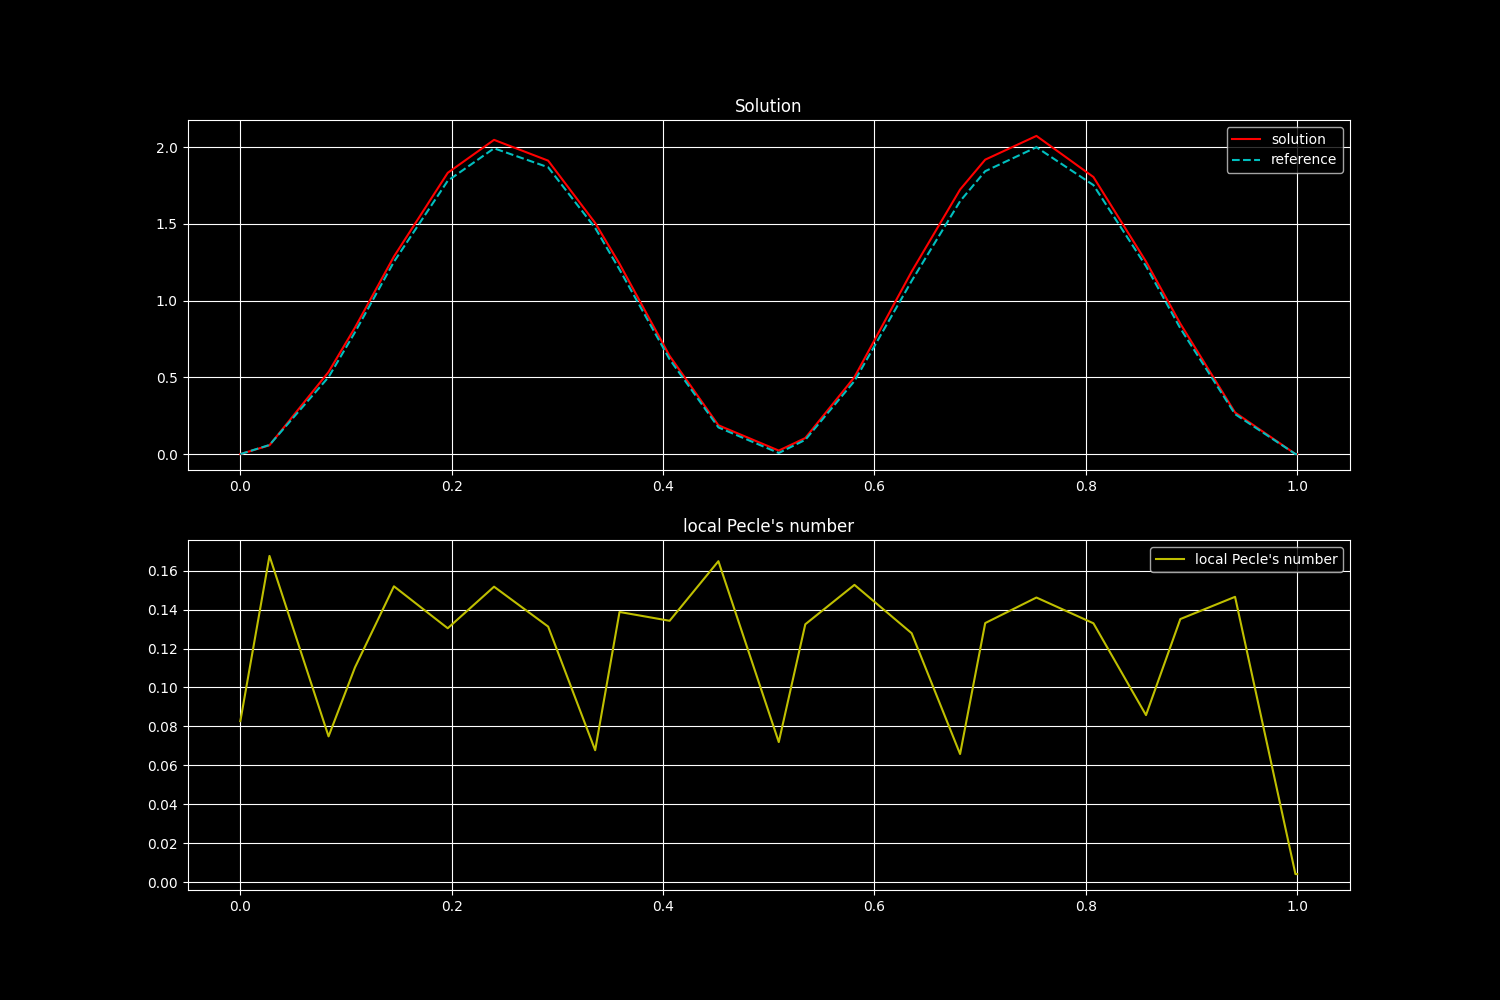

In [6]:
#<solution>
# we have edge task: y[0] = y[N] = 0
def solve (equs):
    x_num = equs.x_data.size
    matrix_n_2 = np.zeros ((x_num - 2, x_num - 2))
    matrix_n_2[0][0] = equs.ai (1)
    matrix_n_2[0][1] = -equs.bii1 (1)
    for i in range (1, x_num - 3):
        matrix_n_2[i][i-1] = -equs.bii_1 (i + 1)
        matrix_n_2[i][i] = equs.ai (i + 1)
        matrix_n_2[i][i+1] = -equs.bii1 (i + 1)
    matrix_n_2[x_num - 3][x_num - 3 - 1] = -equs.bii_1 (x_num - 2)
    matrix_n_2[x_num - 3][x_num - 3] = equs.ai (x_num - 2)
    c_input = str (x_num - 2) + "\n"
    for i in range (0, x_num - 2):
        for j in range (0, x_num - 2):
            c_input = c_input + str (matrix_n_2[i][j]) + " "
        c_input = c_input + str (equs.f[i + 1]) + "\n"
    #print (c_input)
    result = subprocess.run (["./solve_3_daig"], input=c_input, capture_output=True, text=True)
    y = np.zeros (x_num)
    res_split = result.stdout.split ()
    for i in range (1, x_num - 1):
        y[i] = res_split[i - 1]
    return y
    
plt.figure(figsize = (15,10), edgecolor='blue')
plt.subplot (211)
plt.grid (True)
plt.title ("Solution")
plt.plot (eq.x_data, solve (eq), "r-", label="solution")
plt.plot (eq.x_data, eq.y_ref (x_data), "c--", label="reference")
plt.legend()

#<pecle>

plt.subplot (212)
plt.grid (True)
plt.title ("local Pecle's number")
plt.plot (eq.x_data, pecle_data (eq), "y-", label="local Pecle's number")
plt.legend()

#</pecle>

plt.show()

#</solution>

In [7]:
#<mistakes graph calculation>

def mistakes_graph (equation_class, num_start, num_end):
    mistake_graph = np.empty (num_end - num_start)
    for num in range (num_start, num_end):
        temp_x_data = x_data_func (num)
        temp_eq = equation_class (temp_x_data, k_const, monotonesator)
        temp_f_data = solve (temp_eq)
        temp_ref_data = temp_eq.y_ref (temp_x_data)
        max = 0
        for i in range (0, temp_x_data.size):
            if abs (temp_f_data[i] - temp_ref_data[i]) > max:
                max = abs (temp_f_data[i] - temp_ref_data[i])
        mistake_graph[num - num_start] = max
    return mistake_graph

def mistakes_and_pecle_graph (equation_class, num_start, num_end):
    mistake_graph = np.empty (num_end - num_start)
    pecle_graph = np.empty (num_end - num_start)
    for num in range (num_start, num_end):
        temp_x_data = x_data_func (num)
        temp_eq = equation_class (temp_x_data, k_const, monotonesator)
        temp_f_data = solve (temp_eq)
        temp_ref_data = temp_eq.y_ref (temp_x_data)
        temp_pecle_data = pecle_data (temp_eq)
        max = 0
        max_pecle = 0
        for i in range (0, temp_x_data.size):
            if abs (temp_f_data[i] - temp_ref_data[i]) > max:
                max = abs (temp_f_data[i] - temp_ref_data[i])
            if temp_pecle_data[i] > max_pecle:
                max_pecle = temp_pecle_data[i]
        mistake_graph[num - num_start] = max
        pecle_graph[num - num_start] = max_pecle
    res = []
    res.append (mistake_graph)
    res.append (pecle_graph)
    return res

#</mistakes graph calculation>

order, equal h = 2.1356485376036107
order, random h = 2.2042149033818887
order, equal h, monotonesator = 1.128109972168277
order, random h, monotonesator = 1.2709176031196538


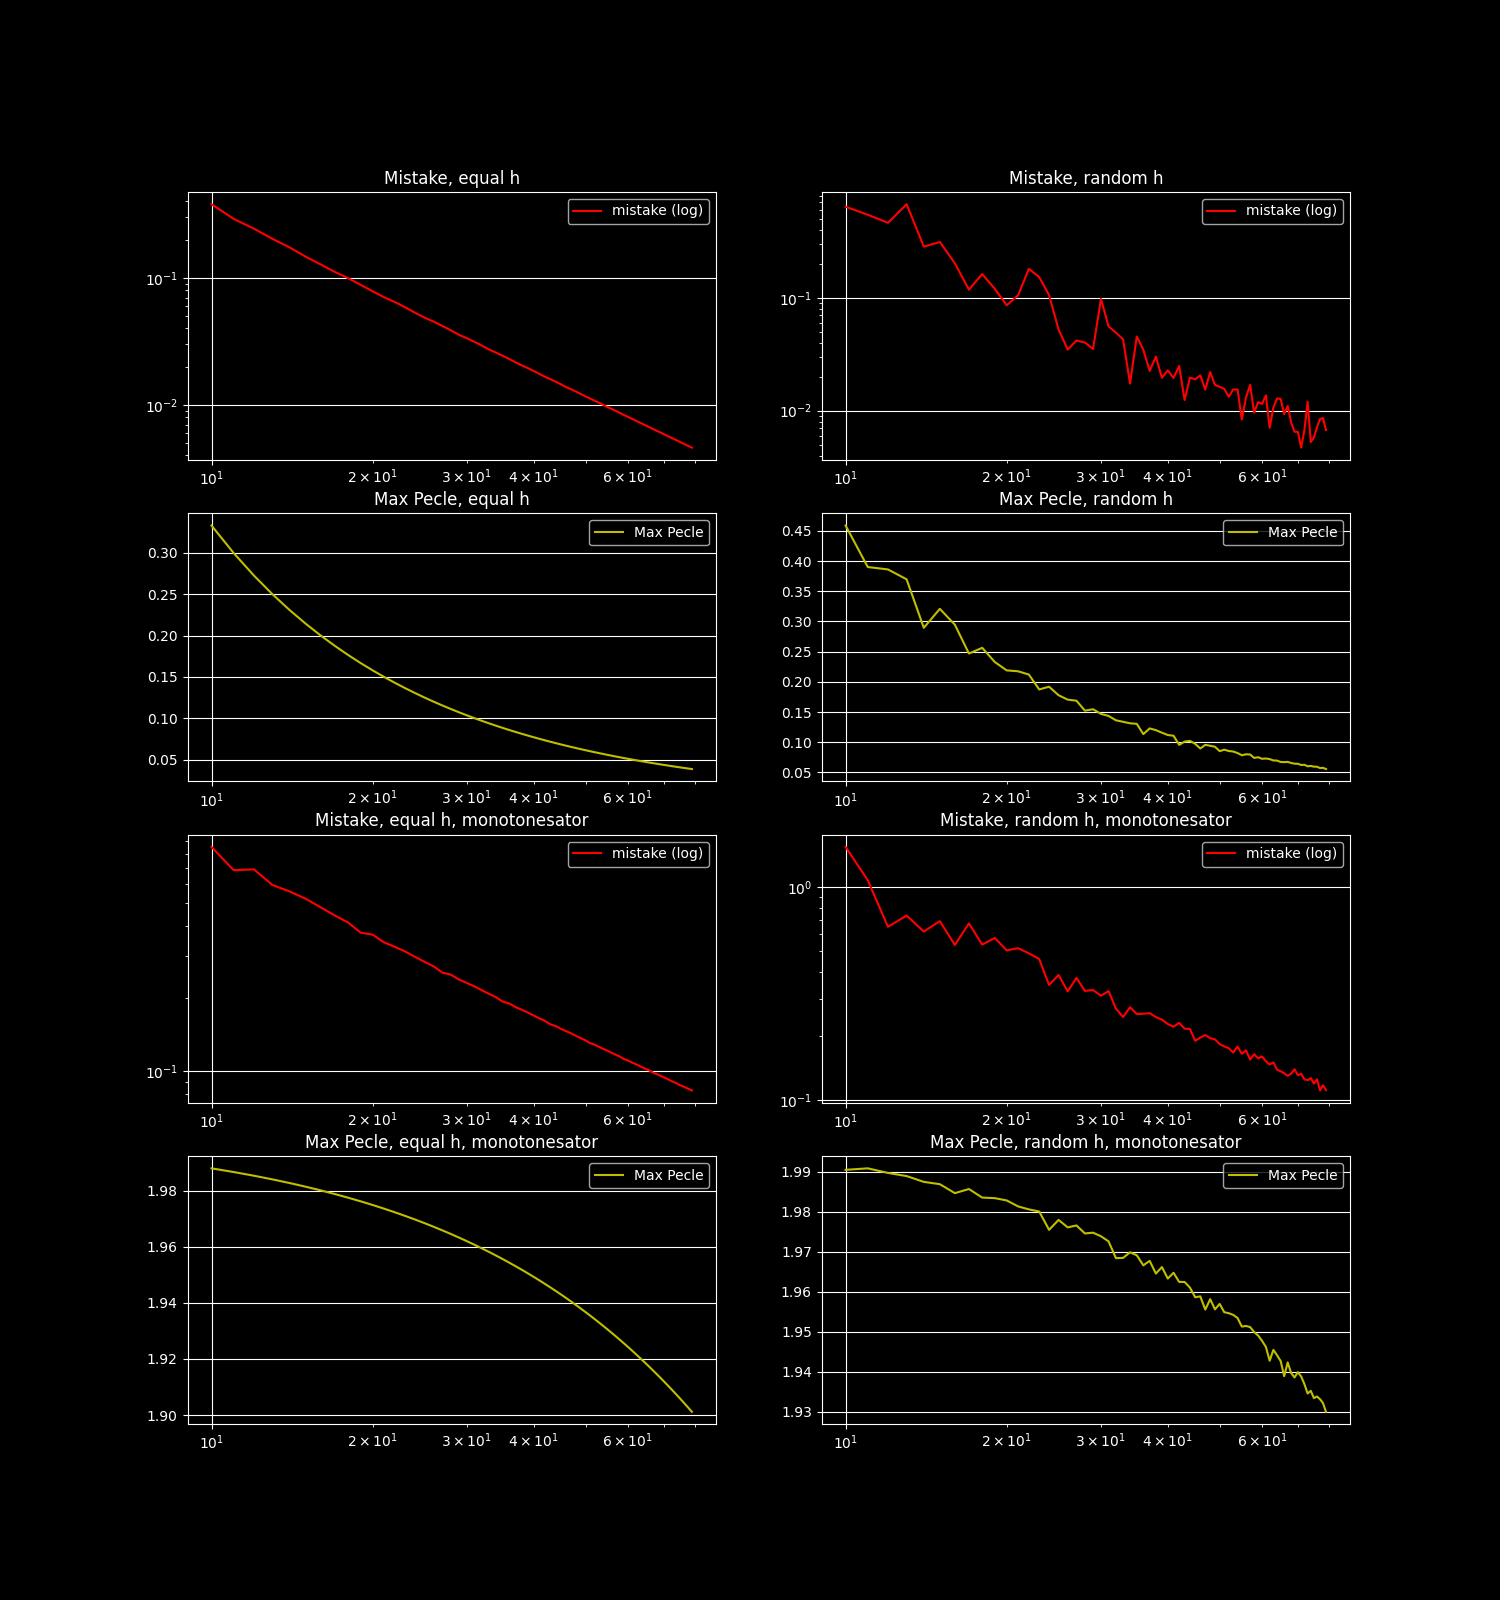

In [10]:
#<order analyze>

monotonesator = False

#<equal h>
x_data_func = x_data_eq

mistake_pecle_graph = mistakes_and_pecle_graph (equations, mistake_num_min, mistake_num_max)
mistake_graph = mistake_pecle_graph[0]
pecle_graph = mistake_pecle_graph[1]
mistake_x_data = np.arange (mistake_num_min, mistake_num_max, 1)

plt.figure(figsize = (15,16))
plt.subplot (421)
plt.title ("Mistake, equal h")
plt.grid (True)
plt.xscale ('log')
plt.yscale ('log')
plt.plot (mistake_x_data, mistake_graph, "r-", label="mistake (log)")
plt.legend()

plt.subplot (423)
plt.title ("Max Pecle, equal h")
plt.grid (True)
plt.xscale ('log')
#plt.yscale ('log')
plt.plot (mistake_x_data, pecle_graph, "y-", label="Max Pecle")
plt.legend()

order = (math.log (mistake_graph[mistake_num_max - mistake_num_min - 1]) - math.log (mistake_graph[0])) / (math.log (mistake_x_data[mistake_num_max - mistake_num_min - 1]) - math.log (mistake_x_data[0]))
print ("order, equal h =", abs (order))

#</equal h>

#<random h>

x_data_func = x_data_rand

mistake_pecle_graph = mistakes_and_pecle_graph (equations, mistake_num_min, mistake_num_max)
mistake_graph = mistake_pecle_graph[0]
pecle_graph = mistake_pecle_graph[1]
mistake_x_data = np.arange (mistake_num_min, mistake_num_max, 1)

plt.subplot (422)
plt.title ("Mistake, random h")
plt.grid (True)
plt.xscale ('log')
plt.yscale ('log')
plt.plot (mistake_x_data, mistake_graph, "r-", label="mistake (log)")
plt.legend()

plt.subplot (424)
plt.title ("Max Pecle, random h")
plt.grid (True)
plt.xscale ('log')
#plt.yscale ('log')
plt.plot (mistake_x_data, pecle_graph, "y-", label="Max Pecle")
plt.legend()

order = (math.log (mistake_graph[mistake_num_max - mistake_num_min - 1]) - math.log (mistake_graph[0])) / (math.log (mistake_x_data[mistake_num_max - mistake_num_min - 1]) - math.log (mistake_x_data[0]))
print ("order, random h =", abs (order))

#</random h>

#<monotonesator>

k_const = 0.001
monotonesator = True

#<equal h>
x_data_func = x_data_eq

mistake_pecle_graph = mistakes_and_pecle_graph (equations, mistake_num_min, mistake_num_max)
mistake_graph = mistake_pecle_graph[0]
pecle_graph = mistake_pecle_graph[1]
mistake_x_data = np.arange (mistake_num_min, mistake_num_max, 1)

plt.subplot (425)
plt.title ("Mistake, equal h, monotonesator")
plt.grid (True)
plt.xscale ('log')
plt.yscale ('log')
plt.plot (mistake_x_data, mistake_graph, "r-", label="mistake (log)")
plt.legend()

plt.subplot (427)
plt.title ("Max Pecle, equal h, monotonesator")
plt.grid (True)
plt.xscale ('log')
#plt.yscale ('log')
plt.plot (mistake_x_data, pecle_graph, "y-", label="Max Pecle")
plt.legend()

order = (math.log (mistake_graph[mistake_num_max - mistake_num_min - 1]) - math.log (mistake_graph[0])) / (math.log (mistake_x_data[mistake_num_max - mistake_num_min - 1]) - math.log (mistake_x_data[0]))
print ("order, equal h, monotonesator =", abs (order))

#</equal h>

#<random h>

x_data_func = x_data_rand

mistake_pecle_graph = mistakes_and_pecle_graph (equations, mistake_num_min, mistake_num_max)
mistake_graph = mistake_pecle_graph[0]
pecle_graph = mistake_pecle_graph[1]
mistake_x_data = np.arange (mistake_num_min, mistake_num_max, 1)

plt.subplot (426)
plt.title ("Mistake, random h, monotonesator")
plt.grid (True)
plt.xscale ('log')
plt.yscale ('log')
plt.plot (mistake_x_data, mistake_graph, "r-", label="mistake (log)")
plt.legend()

plt.subplot (428)
plt.title ("Max Pecle, random h, monotonesator")
plt.grid (True)
plt.xscale ('log')
#plt.yscale ('log')
plt.plot (mistake_x_data, pecle_graph, "y-", label="Max Pecle")
plt.legend()

order = (math.log (mistake_graph[mistake_num_max - mistake_num_min - 1]) - math.log (mistake_graph[0])) / (math.log (mistake_x_data[mistake_num_max - mistake_num_min - 1]) - math.log (mistake_x_data[0]))
print ("order, random h, monotonesator =", abs (order))

#</random h>

k_const = 1
monotonesator = False
#</monotonesator>

plt.show()

#</order analyze>

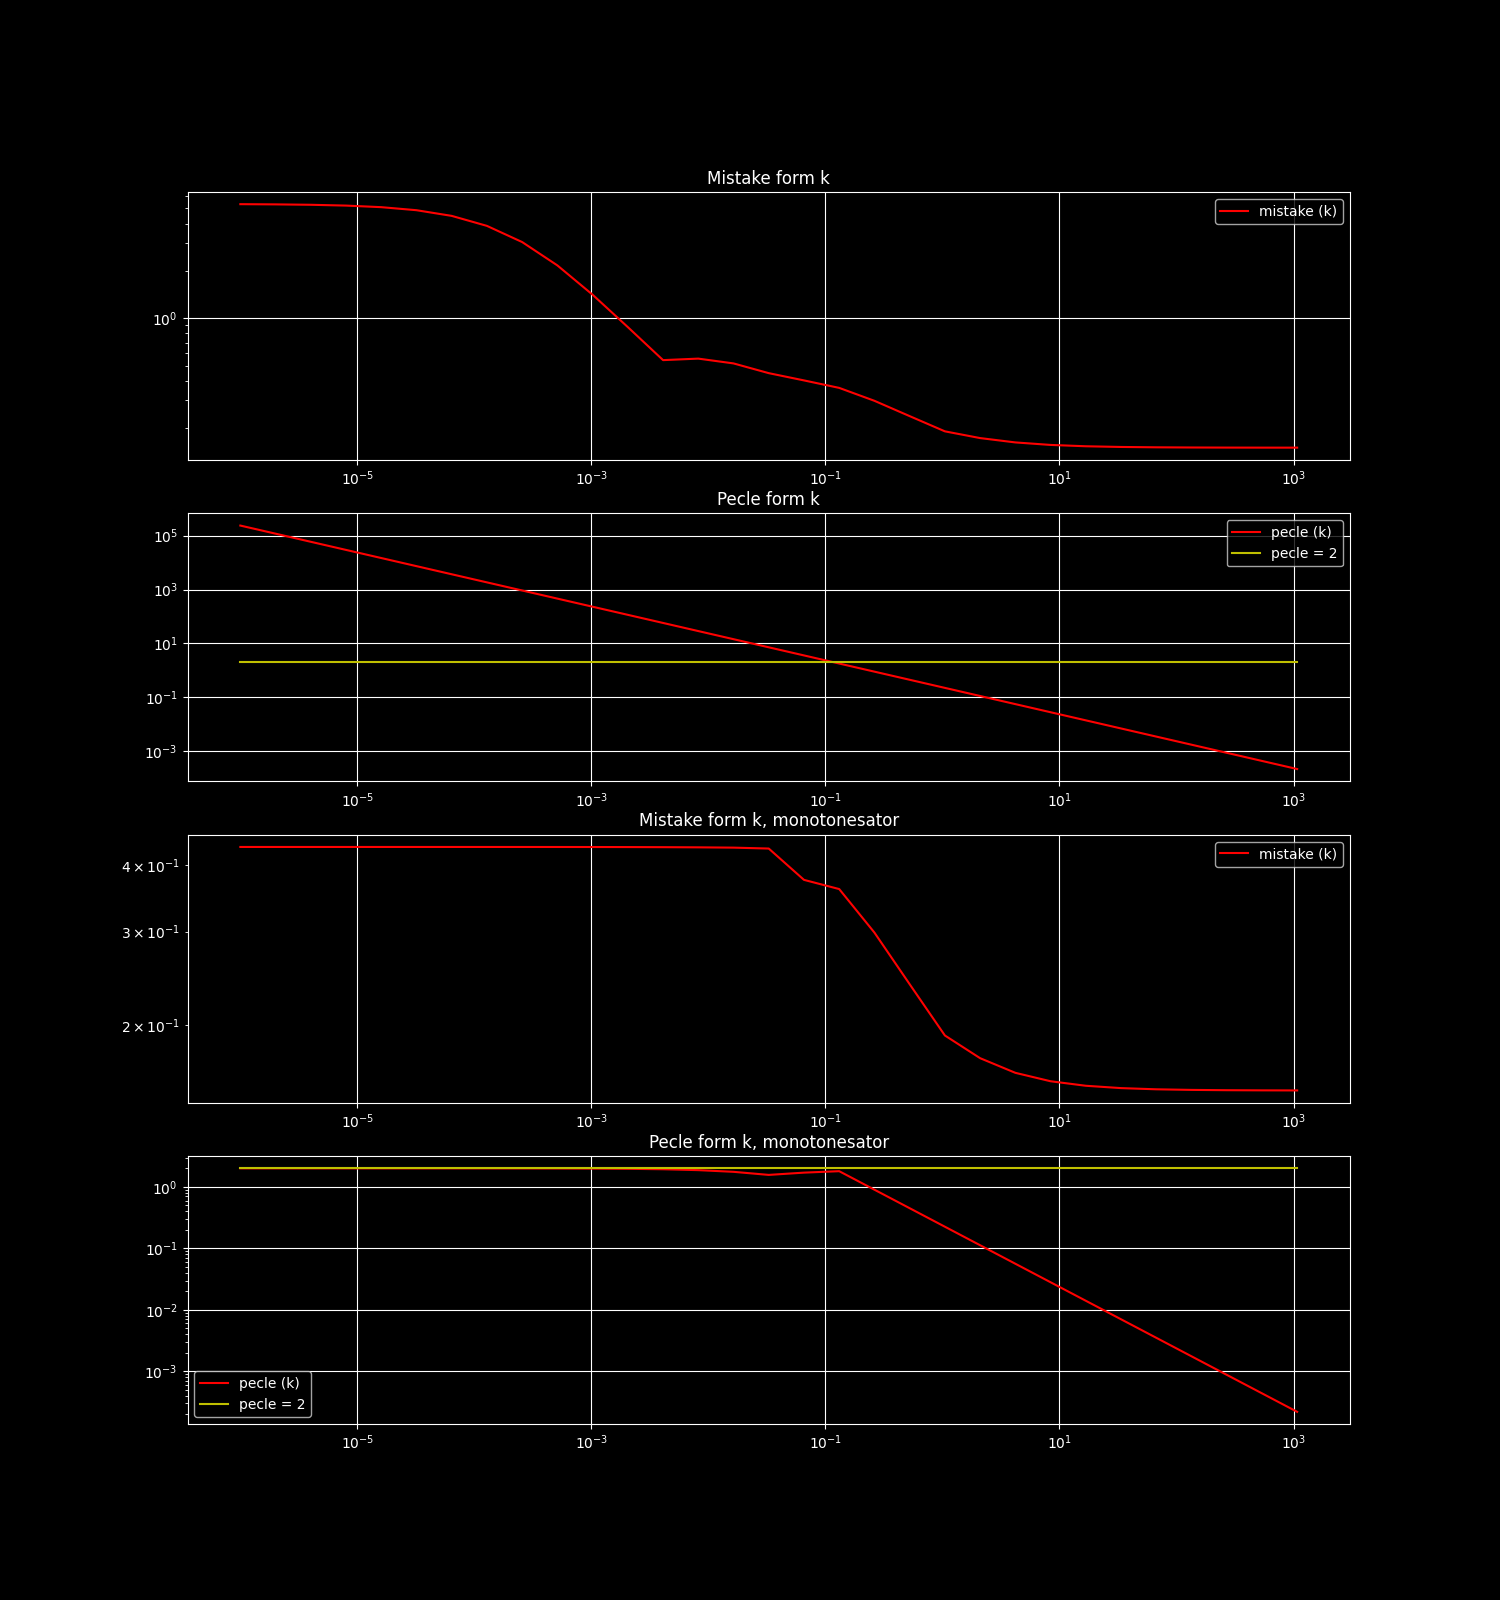

In [9]:
#<k variation>

k_start = 0.000001
mul_num = 30
k_multipler = 2

x_num = 20
x_data_func = x_data_rand
x_data = x_data_func (x_num)

monotonesator = False

def k_var_graph_pecle (equation_class, k_start, mul_num):
    k_graph = np.empty (mul_num + 1)
    pecle_graph = np.empty (mul_num + 1)
    temp_k_const = k_start
    for num in range (0, mul_num + 1):
        temp_eq = equation_class (x_data, temp_k_const, monotonesator)
        temp_f_data = solve (temp_eq)
        temp_ref_data = temp_eq.y_ref (x_data)
        temp_pecle_data = pecle_data (temp_eq)
        max = 0
        max_pecle = 0
        for i in range (0, x_data.size):
            if abs (temp_f_data[i] - temp_ref_data[i]) > max:
                max = abs (temp_f_data[i] - temp_ref_data[i])
            if temp_pecle_data[i] > max_pecle:
                max_pecle = temp_pecle_data[i]
        k_graph[num] = max
        pecle_graph[num] = max_pecle
        temp_k_const = temp_k_const * k_multipler
    res = []
    res.append (k_graph)
    res.append (pecle_graph)
    return res

graphs = k_var_graph_pecle (equations, k_start, mul_num)
k_graph = graphs[0]
pecle_graph = graphs[1]
k_var_data = np.empty (mul_num + 1)
k_var_data[0] = k_start
for i in range (1, mul_num + 1):
    k_var_data[i] = k_var_data[i - 1] * k_multipler
pecle_ref_data = np.zeros (mul_num + 1)
pecle_ref_data = pecle_ref_data + 2

plt.figure(figsize = (15,16))
plt.subplot (411)
plt.title ("Mistake form k")
plt.grid (True)
plt.xscale ('log')
plt.yscale ('log')
plt.plot (k_var_data, k_graph, "r-", label="mistake (k)")
plt.legend()

plt.subplot (412)
plt.title ("Pecle form k")
plt.grid (True)
plt.xscale ('log')
plt.yscale ('log')
plt.plot (k_var_data, pecle_graph, "r-", label="pecle (k)")
plt.plot (k_var_data, pecle_ref_data, "y-", label="pecle = 2")
plt.legend()

#<monotonesator>

monotonesator = True

graphs = k_var_graph_pecle (equations, k_start, mul_num)
k_graph = graphs[0]
pecle_graph = graphs[1]
k_var_data = np.empty (mul_num + 1)
k_var_data[0] = k_start
for i in range (1, mul_num + 1):
    k_var_data[i] = k_var_data[i - 1] * k_multipler
pecle_ref_data = np.zeros (mul_num + 1)
pecle_ref_data = pecle_ref_data + 2

plt.subplot (413)
plt.title ("Mistake form k, monotonesator")
plt.grid (True)
plt.xscale ('log')
plt.yscale ('log')
plt.plot (k_var_data, k_graph, "r-", label="mistake (k)")
plt.legend()

plt.subplot (414)
plt.title ("Pecle form k, monotonesator")
plt.grid (True)
plt.xscale ('log')
plt.yscale ('log')
plt.plot (k_var_data, pecle_graph, "r-", label="pecle (k)")
plt.plot (k_var_data, pecle_ref_data, "y-", label="pecle = 2")
plt.legend()

plt.show ()

#</monotonesator>

#</k variation>